This notebook is designed for QF5214 workshop 2.

You can download this into your computing environment. 

# Part 1: stock signalling

### install dependency
uncomment bellow commands and run if you have not install bellow dependency

In [1]:
from platform import python_version
print(python_version())
import sys
print(sys.executable)
print(sys.version)
print(sys.version_info)

3.10.11
/Users/jhs/.pyenv/versions/3.10.11/bin/python
3.10.11 (main, May  1 2023, 01:38:51) [Clang 16.0.2 ]
sys.version_info(major=3, minor=10, micro=11, releaselevel='final', serial=0)


In [2]:
# you should have installed bellow library in workshop 1.
# you can uncomment them if want to reinstall.

#!pip3 install pandas
#!pip3 install numpy
#!pip3 install yfinance
#!pip3 install bt
#!pip3 install matplotlib
#!pip3 install seaborn
#!pip3 install future
#!pip3 install ffn

### import library 

In [3]:
# import python utility libraries
import os as os
import datetime as dt
import itertools as it
from pprint import pprint

# import python data libraries
import pandas as pd

# import the pandas financial data reader library
import yfinance as yf # a similar library is #from yahoofinancials import YahooFinancials
yf.pdr_override()  # make sure we can access Yahoo! Finance

# import the Python bt backtest library
import bt as bt

# import the matplotlib and seaborn visualization library
import matplotlib.pyplot as plt
import seaborn as sns

# we will use sql this time
import sqlite3
import sqlalchemy

In [4]:
import ffn
import ffn.core
ffn.core.GroupStats

ffn.core.GroupStats

In [5]:
# create a place to store data locally
if not os.path.exists('./datasets'): os.makedirs('./datasets')

### download stock history data from yahoo

In [6]:
# check Apple Stock metadata

aapl = yf.Ticker("AAPL")

## we have previewed bellow information before in workshop 1
# get all stock info
# pprint(aapl.info)

In [7]:
aapl.institutional_holders

,Date Reported,Holder,pctHeld,Shares,Value
0,2023-06-30,Vanguard Group Inc,0.0834,1303688506,252876459508
1,2023-06-30,Blackrock Inc.,0.0665,1039640859,201659137420
2,2023-06-30,"Berkshire Hathaway, Inc",0.0586,915560382,177591247296
3,2023-06-30,State Street Corporation,0.0370,578897858,112288817516
4,2023-06-30,"FMR, LLC",0.0196,307066638,59561715772
5,2023-06-30,"Geode Capital Management, LLC",0.0186,291538165,56549657865
6,2023-06-30,Price (T.Rowe) Associates Inc,0.0145,226650943,43963483413
7,2023-06-30,Morgan Stanley,0.0131,204714950,39708558851
8,2022-12-31,Norges Bank Investment Management,0.0107,167374278,21746939940
9,2023-06-30,Northern Trust Corporation,0.0105,164536073,31915062079


In [8]:
# set to start and end date of the data download
start_date = dt.datetime(2012, 12, 31)
end_date = dt.datetime(2023, 12, 31)

# download 
tickers_list = ['AAPL']

df_aapl = yf.download(tickers_list, start=start_date, end=end_date, progress=True)
print(df_aapl.head())
fn = './datasets/aapl_stock_%s_%s_daily.csv'%(start_date.year, end_date.year)
df_aapl.to_csv(fn, sep=';', encoding='utf-8')
print('saved to %s'%(fn))

[*********************100%%**********************]  1 of 1 completed

                 Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2012-12-31  18.233213  19.121429  18.178572  19.006071  16.233421  659492400
2013-01-02  19.779285  19.821428  19.343929  19.608213  16.747721  560518000
2013-01-03  19.567142  19.631071  19.321428  19.360714  16.536329  352965200
2013-01-04  19.177500  19.236786  18.779642  18.821428  16.075710  594333600
2013-01-07  18.642857  18.903570  18.400000  18.710714  15.981156  484156400
saved to ./datasets/aapl_stock_2012_2023_daily.csv


In [9]:
# data profiling 
df_aapl.describe(include='all')

,Open,High,Low,Close,Adj Close,Volume
count,2769.000000,2769.000000,2769.000000,2769.000000,2769.000000,2.769000e+03
mean,72.287386,73.072702,71.547797,72.344259,70.290188,1.614060e+08
std,56.353171,56.991581,55.762781,56.409949,56.822118,1.239785e+08
min,13.856071,14.271429,13.753571,13.947500,11.982236,2.404830e+07
25%,27.567499,27.930000,27.290001,27.575001,25.148232,8.426790e+07
50%,43.810001,44.299999,43.622501,43.955002,41.858543,1.211508e+08
75%,128.949997,130.600006,127.410004,129.610001,127.486740,1.958040e+08
max,198.020004,199.619995,197.000000,198.110001,197.857529,1.460852e+09


In [10]:
# create sql db file
fn = './datasets/aapl_stock_%s_%s_daily.db'%(start_date.year, end_date.year)
conn = sqlite3.connect(fn)

In [11]:
# check if db file is created or not
! ls -la ./datasets

total 1936
drwxr-xr-x   4 jhs  staff     128  3 Mar 23:59 .
drwxr-xr-x  10 jhs  staff     320  4 Mar 00:02 ..
-rw-r--r--   1 jhs  staff  305086  4 Mar 00:02 aapl_stock_2012_2023_daily.csv
-rw-r--r--   1 jhs  staff  647168  3 Mar 23:59 aapl_stock_2012_2023_daily.db


In [12]:
cur = conn.cursor()

# Create table if necessary
# r = cur.execute('''CREATE TABLE IF NOT EXISTS aapl_daily_raw (Date date, Open real, High real, Low real, Close real, Adj_Close real, Volume real)''')
#print(r)
#conn.commit()

# check if data exists 
#cur.execute("select * from aapl_daily_raw")
#print(len(cur.fetchall()))

In [13]:
# change column name
df_aapl['Adj_Close'] = df_aapl['Adj Close']
df_aapl_to_sql = df_aapl[['Open', 'High', 'Low', 'Close', 'Adj_Close', 'Volume']]


r = cur.execute('''DROP TABLE IF EXISTS aapl_daily_raw''')
conn.commit()

# insert into sql
#df_aapl_to_sql.to_sql(name='aapl_daily_raw', con=conn, if_exists='append') ## 
df_aapl_to_sql.to_sql(name='aapl_daily_raw', con=conn)

# check insert
cur.execute("select * from aapl_daily_raw")
pprint((cur.fetchall())[:5])

[('2012-12-31 00:00:00',
  18.233213424682617,
  19.121429443359375,
  18.178571701049805,
  19.006071090698242,
  16.233421325683594,
  659492400),
 ('2013-01-02 00:00:00',
  19.779285430908203,
  19.821428298950195,
  19.343929290771484,
  19.608213424682617,
  16.74772071838379,
  560518000),
 ('2013-01-03 00:00:00',
  19.567142486572266,
  19.631071090698242,
  19.321428298950195,
  19.360713958740234,
  16.53632926940918,
  352965200),
 ('2013-01-04 00:00:00',
  19.177499771118164,
  19.236785888671875,
  18.77964210510254,
  18.821428298950195,
  16.07571029663086,
  594333600),
 ('2013-01-07 00:00:00',
  18.64285659790039,
  18.9035701751709,
  18.399999618530273,
  18.71071434020996,
  15.981156349182129,
  484156400)]


In [14]:
import pandas
df_aapl_from_sql = pandas.read_sql('SELECT * FROM aapl_daily_raw', conn)
df_aapl_from_sql

,Date,Open,High,Low,Close,Adj_Close,Volume
0,2012-12-31 00:00:00,18.233213,19.121429,18.178572,19.006071,16.233421,659492400
1,2013-01-02 00:00:00,19.779285,19.821428,19.343929,19.608213,16.747721,560518000
2,2013-01-03 00:00:00,19.567142,19.631071,19.321428,19.360714,16.536329,352965200
3,2013-01-04 00:00:00,19.177500,19.236786,18.779642,18.821428,16.075710,594333600
4,2013-01-07 00:00:00,18.642857,18.903570,18.400000,18.710714,15.981156,484156400
...,...,...,...,...,...,...,...
2764,2023-12-22 00:00:00,195.179993,195.410004,192.970001,193.600006,193.353287,37122800
2765,2023-12-26 00:00:00,193.610001,193.889999,192.830002,193.050003,192.803986,28919300
2766,2023-12-27 00:00:00,192.490005,193.500000,191.089996,193.149994,192.903839,48087700
2767,2023-12-28 00:00:00,194.139999,194.660004,193.169998,193.580002,193.333298,34049900


In [15]:
df_aapl_from_sql['Date'] = pandas.to_datetime(df_aapl_from_sql['Date'])
df_aapl_from_sql = df_aapl_from_sql.set_index('Date')

In [16]:
df_aapl = df_aapl_from_sql
df_aapl

,Open,High,Low,Close,Adj_Close,Volume
Date,,,,,,
2012-12-31,18.233213,19.121429,18.178572,19.006071,16.233421,659492400
2013-01-02,19.779285,19.821428,19.343929,19.608213,16.747721,560518000
2013-01-03,19.567142,19.631071,19.321428,19.360714,16.536329,352965200
2013-01-04,19.177500,19.236786,18.779642,18.821428,16.075710,594333600
2013-01-07,18.642857,18.903570,18.400000,18.710714,15.981156,484156400
...,...,...,...,...,...,...
2023-12-22,195.179993,195.410004,192.970001,193.600006,193.353287,37122800
2023-12-26,193.610001,193.889999,192.830002,193.050003,192.803986,28919300
2023-12-27,192.490005,193.500000,191.089996,193.149994,192.903839,48087700


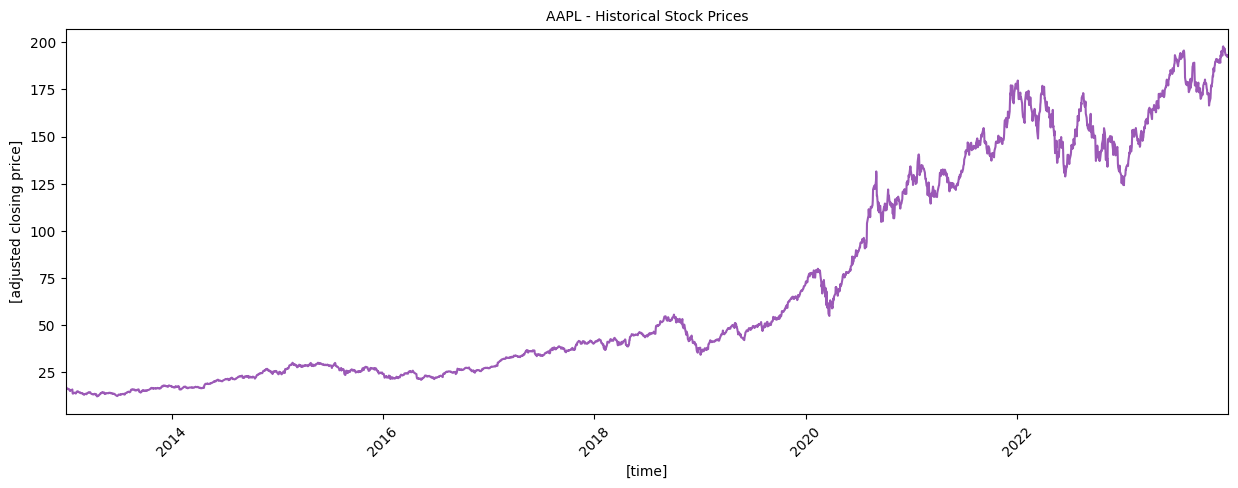

In [17]:
plt.rcParams['figure.figsize'] = [15, 5]
fig = plt.figure()
ax = fig.add_subplot(111)

# plot aapl stock daily adjusted closing prices
ax.plot(df_aapl.index, df_aapl['Adj_Close'], color='#9b59b6')

# rotate x-ticks
for tick in ax.get_xticklabels():
    tick.set_rotation(45)

# set axis labels
ax.set_xlabel('[time]', fontsize=10)
ax.set_xlim([start_date, end_date])
ax.set_ylabel('[adjusted closing price]', fontsize=10)

# set plot title
plt.title('AAPL - Historical Stock Prices', fontsize=10);

### feature for moving average crossover strategy 

In general, crossover trading refers to the idea that changes of market situations can be determined based on price “breakouts”. A crossover can be interpreted as another measure of a financial instruments momentum. In the past crossover signals have been extensively used to determine that it’s time to either buy or sell the underlying asset.

The price crossover signals of a simple Moving Average Crossover trading strategy are triggered by the following events:
- Generate a short trading signal once the price of a financial instrument drops below the general price trend, e.g., 100-days moving average band ("Sell Sign Crossover", left image below).
- Generate a long trading signal once the price of a financial instrument exceeds the general price trend, e.g., 100-days moving average band ("Buy Sign Crossover", right image below).

An enhancement of the Moving Average Crossover is to apply two moving averages to a chart: 
- one long running moving average (e.g., a 200-days SMAV) and one short running moving average (e.g., 20-days SMAV). Once the short running moving average crosses above the long running moving average a Buy or Long signal is triggered, as it indicates that the trend is shifting up (this is known as a "golden cross"). 
- On the other hand, when the short running moving average crosses below the long running moving average, a Sell or Short signal is triggered, as it indicates that the trend is shifting down (his is known as a "dead/death cross")



In [18]:
mav_days_15 = 15  # set "fast" short-running moving average indicator lookback, days = 15
mav_days_60 = 60  # set "slow" short-running moving average indicator lookback, days = 60
mav_days_200 = 200  # set "trend" long-running moving average indicator lookback, days = 200

Calculate the rolling moving averages of window sizes: 15 days, 50 days and 200 days. 

In general the **"Simple Moving Average (SMAV)"** of a financial instrument $i$ (e.g., a stock, commodity, fx-rate) is defined as the mean of the previous $n$ prices, formally denoted by: 

$$SMA_{i}(t)=\frac{1}{n} \sum_{k=0}^{n-1} p_{i}(t-k)$$

were $t$ denotes the current point in time and $n$ the lookback.

We can calculate the SMAV by just using the Pandas `rolling()` and `mean()`function:

In [19]:
smav_15 = pd.Series(df_aapl['Adj_Close'].rolling(window = mav_days_15).mean(), name = 'SMAV_15')
smav_60 = pd.Series(df_aapl['Adj_Close'].rolling(window = mav_days_60).mean(), name = 'SMAV_60')
smav_200 = pd.Series(df_aapl['Adj_Close'].rolling(window = mav_days_200).mean(), name = 'SMAV_200')

In [20]:
df_smav = df_aapl.join(smav_15)
df_smav = df_smav.join(smav_60)
df_smav = df_smav.join(smav_200)

In [21]:
df_smav[['Adj_Close', 'SMAV_15', 'SMAV_60', 'SMAV_200']].iloc[200:210]

,Adj_Close,SMAV_15,SMAV_60,SMAV_200
Date,,,,
2013-10-16,15.579009,15.178147,14.916844,14.045211
2013-10-17,15.684402,15.216034,14.951498,14.039894
2013-10-18,15.820885,15.270212,14.989461,14.036317
2013-10-21,16.208561,15.362670,15.032603,14.036982
2013-10-22,16.162237,15.428807,15.071474,14.037887
2013-10-23,16.320488,15.502178,15.110135,14.039369
2013-10-24,16.536547,15.602699,15.152804,14.043183
2013-10-25,16.351570,15.691676,15.190253,14.045094
2013-10-28,16.473436,15.778994,15.226717,14.048105


### plot 

Plot the historical daily adjusted closing prices (blue) as well as its 15 days (green), 60 days (red) as well as 200 days (yellow) rolling moving averages:

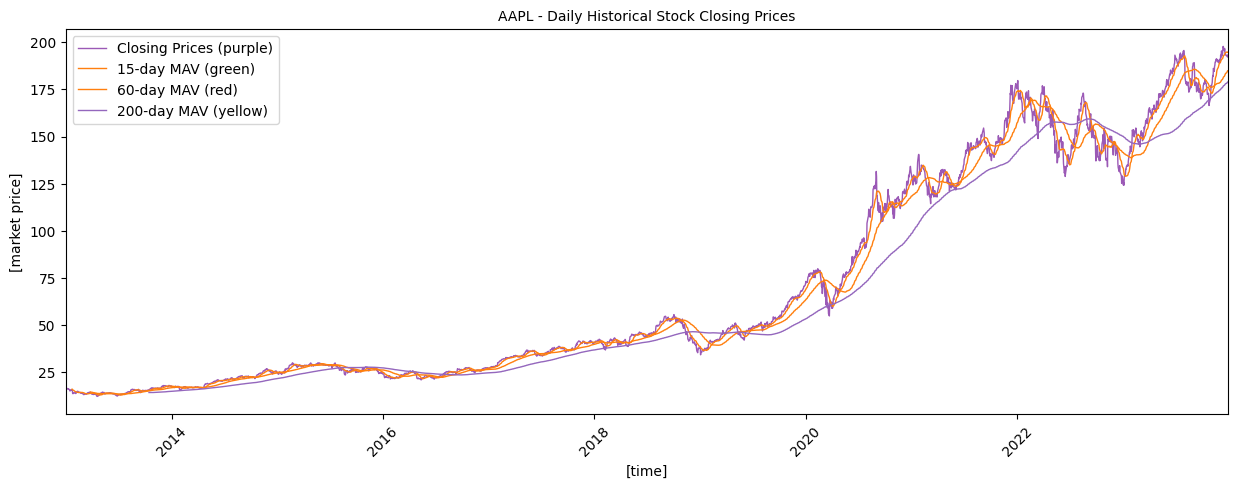

In [22]:
plt.rcParams['figure.figsize'] = [15, 5]
fig = plt.figure()
ax = fig.add_subplot(111)

# plot adjusted closing prices and moving averages
ax.plot(df_smav['Adj_Close'], lw=1.0, color='#9b59b6', label='Closing Prices (purple)')
ax.plot(df_smav['SMAV_15'], color='C1',lw=1.0, label='15-day MAV (green)')
ax.plot(df_smav['SMAV_60'], color='C1',lw=1.0, label='60-day MAV (red)')
ax.plot(df_smav['SMAV_200'], color='C4', lw=1.0, label='200-day MAV (yellow)')

# rotate x-tick labels
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
    
# set axis labels
ax.set_xlabel('[time]', fontsize=10)
ax.set_xlim([start_date, end_date])
ax.set_ylabel('[market price]', fontsize=10)

# set plot legend
plt.legend(loc="upper left", numpoints=1, fancybox=True)

# set plot title
plt.title('AAPL - Daily Historical Stock Closing Prices', fontsize=10);

### generate signal 
Derive trading signals from of two distinct moving average crossover trading strategy configurations. 
- We will generate a **long-signal** (+1.0) for the time intervals where the fast moving averages are above the 200-day moving average. 
- In addition we generate a **short-signal** (-1.0) for the time intervals where the fast moving averages are below the 200-day moving average:

In [23]:
# create 'fast' trend-following signals
df_smav['SIGNAL_15'] = 0.0
df_smav.loc[df_smav['SMAV_15'] > df_smav['SMAV_200'], 'SIGNAL_15'] = 1.0
df_smav.loc[df_smav['SMAV_15'] < df_smav['SMAV_200'], 'SIGNAL_15'] = -1.0

# create 'slow' trend-following signals
df_smav['SIGNAL_60'] = 0.0
df_smav.loc[df_smav['SMAV_60'] > df_smav['SMAV_200'], 'SIGNAL_60'] = 1.0
df_smav.loc[df_smav['SMAV_60'] < df_smav['SMAV_200'], 'SIGNAL_60'] = -1.0

In [24]:
df_smav['SIGNAL_BASE'] = 1.0

In [25]:
# convert signals to Pandas DataFrame
df_signal = pd.DataFrame(df_smav[['SIGNAL_15', 'SIGNAL_60', 'SIGNAL_BASE']], columns=['SIGNAL_15', 'SIGNAL_60', 'SIGNAL_BASE'])

# convert pandas DataFrame index to datatype: datetime
df_signal = df_signal.set_index(pd.to_datetime(df_aapl.index))

In [26]:
df_signal.head(10)

,SIGNAL_15,SIGNAL_60,SIGNAL_BASE
Date,,,
2012-12-31,0.0,0.0,1.0
2013-01-02,0.0,0.0,1.0
2013-01-03,0.0,0.0,1.0
2013-01-04,0.0,0.0,1.0
2013-01-07,0.0,0.0,1.0
2013-01-08,0.0,0.0,1.0
2013-01-09,0.0,0.0,1.0
2013-01-10,0.0,0.0,1.0
2013-01-11,0.0,0.0,1.0


Inspect some of the exemplary signal deviations between the 15-days and 60-days crossover moving average trading strategies:

In [27]:
df_signal[df_signal['SIGNAL_15'] != df_signal['SIGNAL_60']].head(10)

,SIGNAL_15,SIGNAL_60,SIGNAL_BASE
Date,,,
2015-08-11,-1.0,1.0,1.0
2015-08-12,-1.0,1.0,1.0
2015-08-13,-1.0,1.0,1.0
2015-08-14,-1.0,1.0,1.0
2015-08-17,-1.0,1.0,1.0
2015-08-18,-1.0,1.0,1.0
2015-08-19,-1.0,1.0,1.0
2015-08-20,-1.0,1.0,1.0
2015-08-21,-1.0,1.0,1.0


Visualize the prepared trading signals:

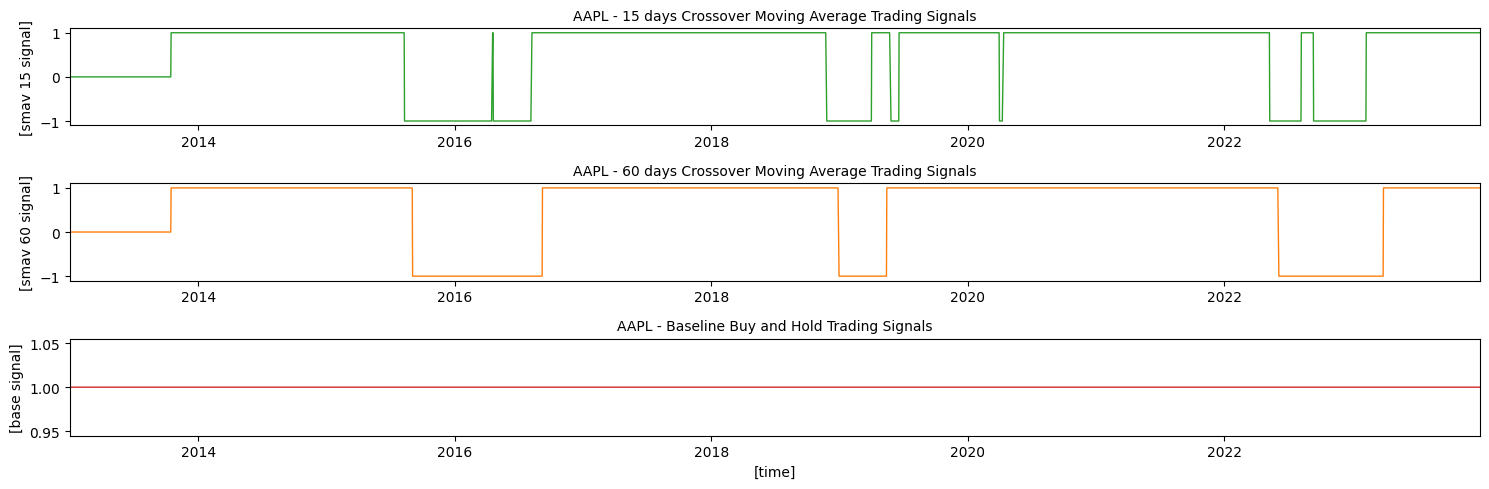

In [28]:
plt.rcParams['figure.figsize'] = [15, 5]
fig, ax = plt.subplots(ncols=1, nrows=3)

ax[0].plot(df_signal['SIGNAL_15'], lw=1.0, color='C2', label='SMAV 15 (red)')
ax[1].plot(df_signal['SIGNAL_60'], lw=1.0, color='C1', label='SMAV 60 (green)')
ax[2].plot(df_signal['SIGNAL_BASE'], lw=1.0, color='C3', label='BASE (purple)')
    
# set axis labels
plt.xlabel('[time]', fontsize=10)
ax[0].set_xlim([start_date, end_date])
ax[0].set_ylabel('[smav 15 signal]', fontsize=10)
ax[1].set_xlim([start_date, end_date])
ax[1].set_ylabel('[smav 60 signal]', fontsize=10)
ax[2].set_xlim([start_date, end_date])
ax[2].set_ylabel('[base signal]', fontsize=10)

# rotate the x-axis labels
'''
for tick in ax[0].get_xticklabels():
    tick.set_rotation(45)
    
for tick in ax[1].get_xticklabels():
    tick.set_rotation(45)
    
for tick in ax[2].get_xticklabels():
    tick.set_rotation(45)
'''

# set plot title
ax[0].set_title('AAPL - 15 days Crossover Moving Average Trading Signals', fontsize=10)
ax[1].set_title('AAPL - 60 days Crossover Moving Average Trading Signals', fontsize=10)
ax[2].set_title('AAPL - Baseline Buy and Hold Trading Signals', fontsize=10)

# reset plot layout
plt.tight_layout()

Let's determine the total number of **long-short signal changes** of the distinct trading strategies:

In [29]:
# signal changes of the 15-200 days moving average crossover trading strategy
turn_15 = len(list(it.groupby(df_signal['SIGNAL_15'], lambda x: x > 0)))
# signal changes of the 60-200 days moving average crossover trading strategy
turn_60 = len(list(it.groupby(df_signal['SIGNAL_60'], lambda x: x > 0)))
# signal changes of the baseline buy and hold trading strategy
turn_200 = len(list(it.groupby(df_signal['SIGNAL_BASE'], lambda x: x > 0)))

print("tunring points SMAV 15: ", turn_15)
print("tunring points SMAV 60: ", turn_60)
print("tunring points SMAV 200: ", turn_200)

tunring points SMAV 15:  16
tunring points SMAV 60:  8
tunring points SMAV 200:  1


### signal backtest

Define the moving average trading strategy backtest algorithm stack. 

**Note:** That in the Python `bt` library a trading strategy usually consists of a so-called **stack of algorithms**. For each timestep of our backtest timeframe, the `bt` library executes all algorithm of the stack in sequential order. Each moving average strategy we aim to design and backtest consists in total of three algorithms, briefly described in the following: 

> 1. `bt.algos.SelectAll()`: Selects all available stocks for trading except stock prices that correspond to NaN or 0.00.  
> 2. `MovingAverageStrategy()`: Assigns the calculated signal in terms of a weight value to the AAPL stock.
> 3. `bt.algos.Rebalance()`: Rebalances the available capital based on the weights assigned to each stock.

In [30]:
# extract the AAPL stock closing prices
df_bt = pd.DataFrame(df_aapl['Adj_Close'], columns=['Adj_Close'])

# rename the 'close' column to 'aapl' (since this is the column we want to allocate to in the backtest)
df_bt = df_bt.rename(columns={'Adj_Close': 'aapl'})

# convert pandas DataFrame index to datatype: datetime
df_bt = df_bt.set_index(pd.to_datetime(df_aapl.index))

In [31]:
df_bt.head(10)

,aapl
Date,
2012-12-31,16.233421
2013-01-02,16.747721
2013-01-03,16.536329
2013-01-04,16.075710
2013-01-07,15.981156
2013-01-08,16.024164
2013-01-09,15.773719
2013-01-10,15.969262
2013-01-11,15.871343


In [32]:
class MovingAverageStrategy(bt.Algo):
    
    # inits the strategy
    def __init__(self, signals):
        
        # set class signals
        self.signals = signals
        
    # calss the trading strategy
    def __call__(self, target):
        
        # case: current timestep in signals
        if target.now in self.signals.index[1:]:
            
            # get actual signal
            signal = self.signals[target.now]
            
            # set target weights according to signal
            target.temp['weights'] = dict(aapl=signal)
            
        # return 'True' since we want to move on to the next timestep
        return True

In [33]:
strategy_15 = bt.Strategy(name='smav_15', algos=[bt.algos.SelectAll(), MovingAverageStrategy(df_signal['SIGNAL_15']), bt.algos.Rebalance()])
strategy_60 = bt.Strategy(name='smav_60', algos=[bt.algos.SelectAll(), MovingAverageStrategy(df_signal['SIGNAL_60']), bt.algos.Rebalance()])
strategy_base = bt.Strategy(name='base', algos=[bt.algos.SelectAll(), MovingAverageStrategy(df_signal['SIGNAL_BASE']), bt.algos.Rebalance()])

In [34]:
# init trading fees function
def trading_fees_function(q, p):
    
    # calcluate trading fees (rebalanced-quantity * trading-fee)
    #fees = q * 0.01 # non-flat fee of 1% per quantity of rebalanced asset
    fees = 5.00 # flat fee of USD 5.00 per trade
    
    # return the total trading fees
    return fees

In [35]:
bt_15 = bt.Backtest(strategy=strategy_15, data=df_bt, name='backtest_smav_15', commissions=trading_fees_function, progress_bar=True)
bt_60 = bt.Backtest(strategy=strategy_60, data=df_bt, name='backtest_smav_60', commissions=trading_fees_function, progress_bar=True)
bt_base = bt.Backtest(strategy=strategy_base, data=df_bt, name='backtest_smav_base', commissions=trading_fees_function, progress_bar=True)

In [36]:
backtest_results = bt.run(bt_15, bt_60, bt_base)

backtest_smav_15
0% [############################# ] 100% | ETA: 00:00:00backtest_smav_60
0% [############################# ] 100% | ETA: 00:00:00backtest_smav_base
0% [############################# ] 100% | ETA: 00:00:00

In [37]:
backtest_results.display()

Stat                 backtest_smav_15    backtest_smav_60    backtest_smav_base
-------------------  ------------------  ------------------  --------------------
Start                2012-12-30          2012-12-30          2012-12-30
End                  2023-12-29          2023-12-29          2023-12-29
Risk-free rate       0.00%               0.00%               0.00%

Total Return         315.34%             438.32%             1048.11%
Daily Sharpe         0.61                0.70                0.93
Daily Sortino        0.99                1.15                1.52
CAGR                 13.83%              16.54%              24.85%
Max Drawdown         -49.16%             -50.95%             -38.52%
Calmar Ratio         0.28                0.32                0.65

MTD                  1.36%               1.36%               1.36%
3m                   12.60%              12.60%              12.60%
6m                   1.82%               1.82%               1.82%
YTD               

### backtest details 15

Collect detailed backtest performance per timestep of the "fast" **15-200 days** crossover moving average strategy:

In [38]:
    
df_bt_details_15 = bt_15.strategy.prices.to_frame(name='Rel. EQUITY')
df_bt_details_15['Abs. EQUITY'] = bt_15.strategy.values # equity per timestep
df_bt_details_15['CASH'] = bt_15.strategy.cash # cash per timestep
df_bt_details_15['POSITIONS'] = bt_15.strategy.positions # positions per timestep
df_bt_details_15['FEES'] = bt_15.strategy.fees # trading fees per timestep

df_bt_details_15

,Rel. EQUITY,Abs. EQUITY,CASH,POSITIONS,FEES
2012-12-30,100.000000,1.000000e+06,1000000.000000,0.0,0.0
2012-12-31,100.000000,1.000000e+06,1000000.000000,0.0,0.0
2013-01-02,100.000000,1.000000e+06,1000000.000000,0.0,0.0
2013-01-03,100.000000,1.000000e+06,1000000.000000,0.0,0.0
2013-01-04,100.000000,1.000000e+06,1000000.000000,0.0,0.0
...,...,...,...,...,...
2023-12-22,417.645296,4.176453e+06,21.963772,21600.0,0.0
2023-12-26,416.458805,4.164588e+06,21.963772,21600.0,0.0
2023-12-27,416.674489,4.166745e+06,21.963772,21600.0,0.0
2023-12-28,417.602119,4.176021e+06,21.963772,21600.0,0.0


Visualize the monthly returns obtained by the **15-200 days** crossover moving average strategy:

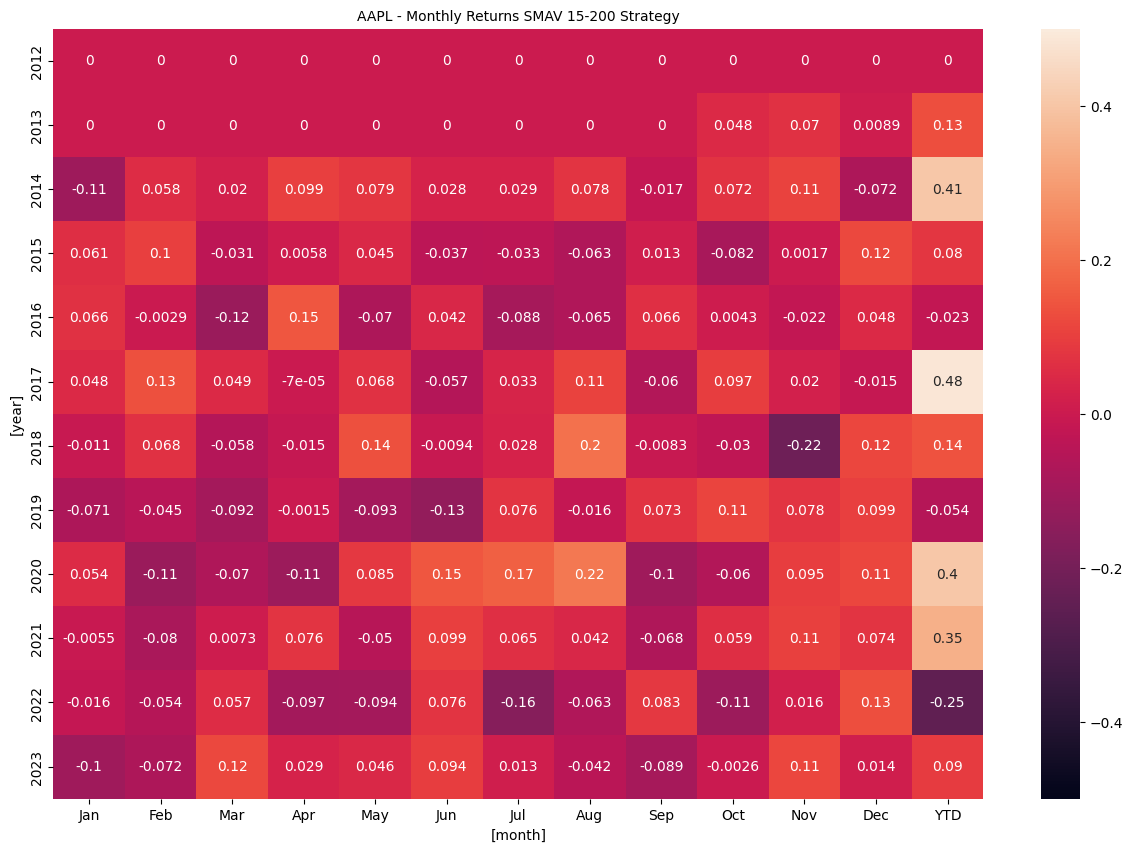

In [39]:
plt.rcParams['figure.figsize'] = [15, 10]
fig = plt.figure()
ax = fig.add_subplot(111)

# plot heatmap of monthly returns generated by the strategy
ax = sns.heatmap(bt_15.stats.return_table, annot=True, cbar=True, vmin=-0.5, vmax=0.5)

# set axis labels
ax.set_xlabel('[month]', fontsize=10)
ax.set_ylabel('[year]', fontsize=10)

# set plot title
ax.set_title('AAPL - Monthly Returns SMAV 15-200 Strategy', fontsize=10);

### backtest details 60

Collect detailed backtest performance per timestep of the "fast" **60-200 days** crossover moving average strategy:

In [40]:
df_bt_details_60 = bt_60.strategy.prices.to_frame(name='Rel. EQUITY')
df_bt_details_60['Abs. EQUITY'] = bt_60.strategy.values # equity per timestep
df_bt_details_60['CASH'] = bt_60.strategy.cash # cash per timestep
df_bt_details_60['POSITIONS'] = bt_60.strategy.positions # positions per timestep
df_bt_details_60['FEES'] = bt_60.strategy.fees # trading fees per timestep

df_bt_details_60

,Rel. EQUITY,Abs. EQUITY,CASH,POSITIONS,FEES
2012-12-30,100.000000,1.000000e+06,1000000.000000,0.0,0.0
2012-12-31,100.000000,1.000000e+06,1000000.000000,0.0,0.0
2013-01-02,100.000000,1.000000e+06,1000000.000000,0.0,0.0
2013-01-03,100.000000,1.000000e+06,1000000.000000,0.0,0.0
2013-01-04,100.000000,1.000000e+06,1000000.000000,0.0,0.0
...,...,...,...,...,...
2023-12-22,541.307384,5.413074e+06,148.581402,27995.0,0.0
2023-12-26,539.769616,5.397696e+06,148.581402,27995.0,0.0
2023-12-27,540.049156,5.400492e+06,148.581402,27995.0,0.0
2023-12-28,541.251425,5.412514e+06,148.581402,27995.0,0.0


Visualize the monthly returns obtained by the **60-200 days** crossover moving average strategy:

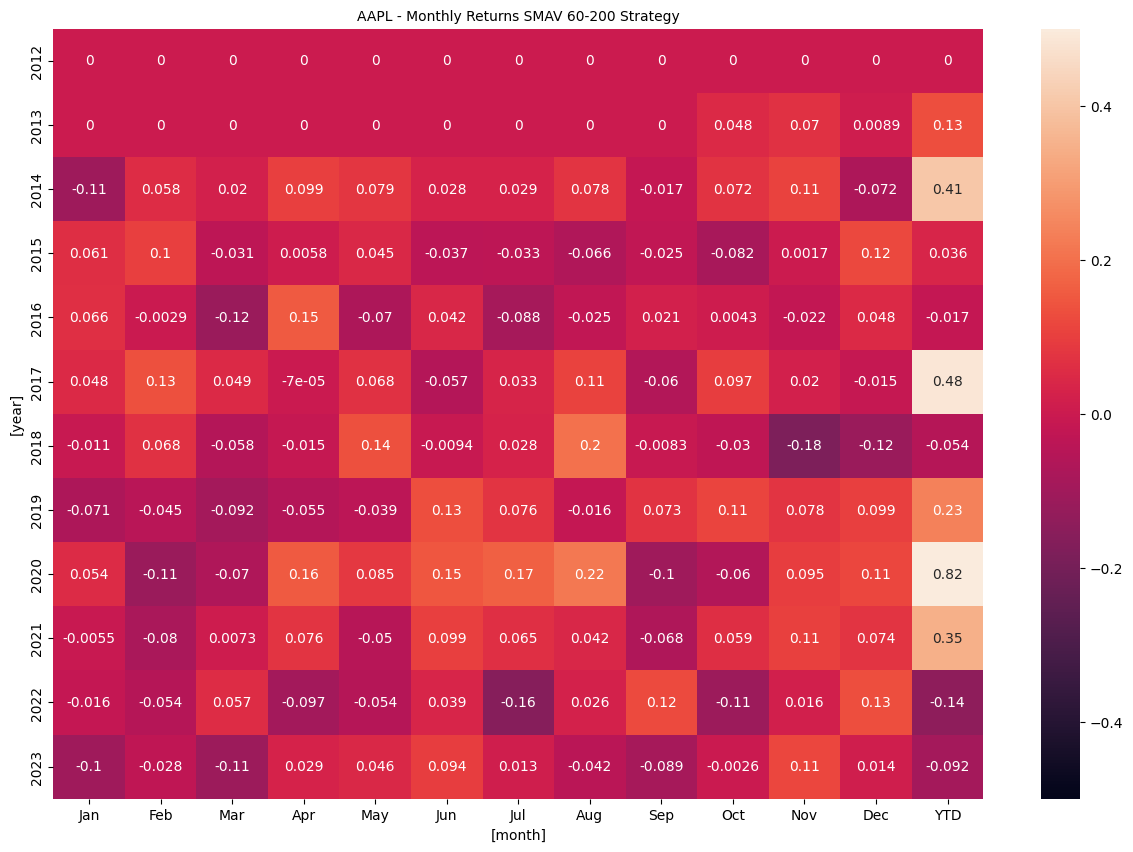

In [41]:
plt.rcParams['figure.figsize'] = [15, 10]
fig = plt.figure()
ax = fig.add_subplot(111)

# plot heatmap of monthly returns generated by the strategy
ax = sns.heatmap(bt_60.stats.return_table, annot=True, cbar=True, vmin=-0.5, vmax=0.5)

# set axis labels
ax.set_xlabel('[month]', fontsize=10)
ax.set_ylabel('[year]', fontsize=10)

# set plot title
ax.set_title('AAPL - Monthly Returns SMAV 60-200 Strategy', fontsize=10);

### backtest details 60

Collect detailed backtest performance per timestep of the "long only" baseline strategy:

In [42]:
    
df_bt_details_base = bt_base.strategy.prices.to_frame(name='Rel. EQUITY')
df_bt_details_base['Abs. EQUITY'] = bt_base.strategy.values # equity per timestep
df_bt_details_base['CASH'] = bt_base.strategy.cash # cash per timestep
df_bt_details_base['POSITIONS'] = bt_base.strategy.positions # positions per timestep
df_bt_details_base['FEES'] = bt_base.strategy.fees # trading fees per timestep

df_bt_details_base

,Rel. EQUITY,Abs. EQUITY,CASH,POSITIONS,FEES
2012-12-30,100.000000,1.000000e+06,1000000.000000,0.0,0.0
2012-12-31,100.000000,1.000000e+06,1000000.000000,0.0,0.0
2013-01-02,99.999500,9.999950e+05,5.343626,59709.0,5.0
2013-01-03,98.737303,9.873730e+05,5.343626,59709.0,0.0
2013-01-04,95.986993,9.598699e+05,5.343626,59709.0,0.0
...,...,...,...,...,...
2023-12-22,1154.493674,1.154494e+07,5.343626,59709.0,0.0
2023-12-26,1151.213852,1.151214e+07,5.343626,59709.0,0.0
2023-12-27,1151.810067,1.151810e+07,5.343626,59709.0,0.0
2023-12-28,1154.374322,1.154374e+07,5.343626,59709.0,0.0


Visualize the monthly returns obtained by the **long only** crossover moving average strategy:

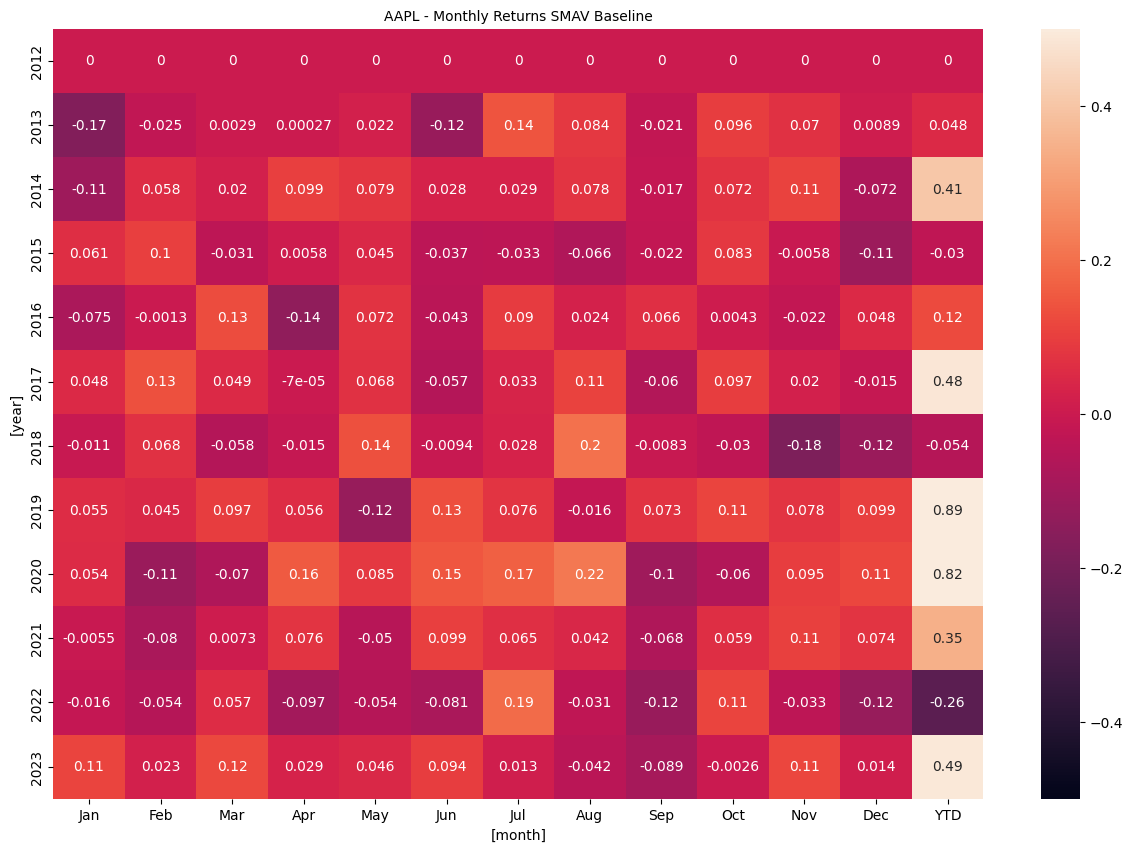

In [43]:
plt.rcParams['figure.figsize'] = [15, 10]
fig = plt.figure()
ax = fig.add_subplot(111)

# plot heatmap of monthly returns generated by the strategy
ax = sns.heatmap(bt_base.stats.return_table, annot=True, cbar=True, vmin=-0.5, vmax=0.5)

# set axis labels
ax.set_xlabel('[month]', fontsize=10)
ax.set_ylabel('[year]', fontsize=10)

# set plot title
ax.set_title('AAPL - Monthly Returns SMAV Baseline', fontsize=10);

Visualize each strategie's backtest equity progression over time:

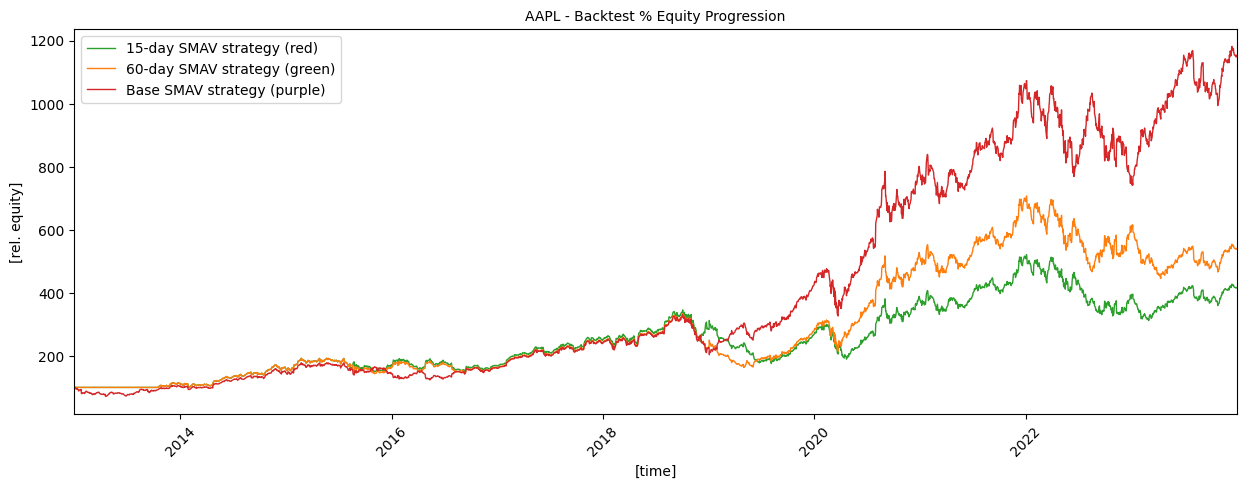

In [44]:
plt.rcParams['figure.figsize'] = [15, 5]
fig = plt.figure()
ax = fig.add_subplot(111)

# plot equity progression of the distinct trading strategies
ax.plot(df_bt_details_15['Rel. EQUITY'], color='C2',lw=1.0, label='15-day SMAV strategy (red)')
ax.plot(df_bt_details_60['Rel. EQUITY'], color='C1',lw=1.0, label='60-day SMAV strategy (green)')
ax.plot(df_bt_details_base['Rel. EQUITY'], color='C3',lw=1.0, label='Base SMAV strategy (purple)')

# rotate x-tick labels
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
    
# set axis labels
ax.set_xlabel('[time]', fontsize=10)
ax.set_xlim([start_date, end_date])
ax.set_ylabel('[rel. equity]', fontsize=10)

# set plot legend
plt.legend(loc="upper left", numpoints=1, fancybox=True)

# set plot title
plt.title('AAPL - Backtest % Equity Progression', fontsize=10);

# Part 2: Alternative data: web scraping

In [45]:
# bellow should be installed in workshop 1

#!pip3 install selenium
#!pip3 install beautifulsoup4

In [46]:
# bellow should be installed in workshop 1

# install chromedriver if not exists
#!brew install --cask chromedriver # for mac
#!apt install chromium-chromedriver -y # for linux
#!apt info chromium-chromedriver
#!ls /usr/lib/chromium-browser/

In [47]:
# library to scrape webpage
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
options = webdriver.ChromeOptions()
options.add_argument('--headless')
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-ahm-usage')
print(options)
service = Service(executable_path=r'/opt/homebrew/bin/chromedriver') # change to your path of chromedriver if different, for mac
#service = Service(executable_path='/usr/lib/chromium-browser/chromedriver') # change to your path of chromedriver if different, for linux
driver = webdriver.Chrome(service=service, options=options)

In [48]:
# library to parse webpage
from bs4 import BeautifulSoup
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.common.exceptions import TimeoutException
from time import sleep
delay = 5 #secods

In [49]:
# this file may need to run several time if runing on linux

url = 'https://en.wikipedia.org/wiki/Timeline_of_Apple_Inc._products'
print(url)
driver.get(url)
WebDriverWait(driver, delay)
#sleep(5)

https://en.wikipedia.org/wiki/Timeline_of_Apple_Inc._products


<selenium.webdriver.support.wait.WebDriverWait (session="8f0e76b8ceb4aaef1444c3e971fcda3c")>

In [50]:
html = driver.execute_script("return document.getElementsByTagName('html')[0].innerHTML")
soup = BeautifulSoup(html, "html.parser")

![Link Name](./assets/wikitable.png)  

In [51]:
# support function parse wikitable, because wikitable has a rowsspan and columnspan which is special.

import pandas as pd
import numpy as np

def pre_process_table(table):
    """
    INPUT:
        1. table - a bs4 element that contains the desired table: ie <table> ... </table>
    OUTPUT:
        a tuple of: 
            1. rows - a list of table rows ie: list of <tr>...</tr> elements
            2. num_rows - number of rows in the table
            3. num_cols - number of columns in the table
    Options:
        include_td_head_count - whether to use only th or th and td to count number of columns (default: False)
    """
    rows = [x for x in table.find_all('tr')]

    num_rows = len(rows)

    # get an initial column count. Most often, this will be accurate
    num_cols = max([len(x.find_all(['th','td'])) for x in rows])

    # sometimes, the tables also contain multi-colspan headers. This accounts for that:
    header_rows_set = [x.find_all(['th', 'td']) for x in rows if len(x.find_all(['th', 'td']))>num_cols/2]

    num_cols_set = []

    for header_rows in header_rows_set:
        num_cols = 0
        for cell in header_rows:
            row_span, col_span = get_spans(cell)
            num_cols+=len([cell.getText()]*col_span)

        num_cols_set.append(num_cols)

    num_cols = max(num_cols_set)

    return (rows, num_rows, num_cols)


def get_spans(cell):
        """
        INPUT:
            1. cell - a <td>...</td> or <th>...</th> element that contains a table cell entry
        OUTPUT:
            1. a tuple with the cell's row and col spans
        """
        if cell.has_attr('rowspan'):
            rep_row = int(cell.attrs['rowspan'])
        else: # ~cell.has_attr('rowspan'):
            rep_row = 1
        if cell.has_attr('colspan'):
            rep_col = int(cell.attrs['colspan'])
        else: # ~cell.has_attr('colspan'):
            rep_col = 1 

        return (rep_row, rep_col)

def process_rows(rows, num_rows, num_cols):
    """
    INPUT:
        1. rows - a list of table rows ie <tr>...</tr> elements
    OUTPUT:
        1. data - a Pandas dataframe with the html data in it
    """
    data = pd.DataFrame(np.ones((num_rows, num_cols))*np.nan)
    for i, row in enumerate(rows):
        try:
            col_stat = data.iloc[i,:][data.iloc[i,:].isnull()].index[0]
        except IndexError:
            print(i, row)

        for j, cell in enumerate(row.find_all(['td', 'th'])):
            rep_row, rep_col = get_spans(cell)

            #print("cols {0} to {1} with rep_col={2}".format(col_stat, col_stat+rep_col, rep_col))
            #print("\trows {0} to {1} with rep_row={2}".format(i, i+rep_row, rep_row))

            #find first non-na col and fill that one
            while any(data.iloc[i,col_stat:col_stat+rep_col].notnull()):
                col_stat+=1

            data.iloc[i:i+rep_row,col_stat:col_stat+rep_col] = cell.getText()
            if col_stat<data.shape[1]-1:
                col_stat+=rep_col

    return data

In [52]:
# parse to get detailed data in wikitable

tables = []
for table in soup.find_all('table'):
    if not 'wikitable' in table.get('class'):
        continue
    if not "released" in table.text.lower():
        continue
    tables.append(table)

dfs = []
i = 0
for table in tables:
    i = i + 1
    #print(table.text)
    rows, num_rows, num_cols = pre_process_table(table)
    df1 = process_rows(rows, num_rows, num_cols)
    dfs.append(df1)
    
df_timeline = pd.concat(dfs, ignore_index=True)
df_timeline = df_timeline.rename(columns={0: 'released', 1:'model', 2:'family', 3:'discounted'})
#print(df_timeline)
df_timeline['released'] = df_timeline['released'].str.strip()
df_timeline['model'] = df_timeline['model'].str.strip()
df_timeline['family'] = df_timeline['family'].str.strip()
df_timeline['discounted'] = df_timeline['discounted'].str.strip()
df_timeline

,released,model,family,discounted
0,Released,Model,Family,Discontinued
1,"April 11, 1976",Apple I,Apple I,"September 30, 1977"
2,"June 1, 1977",Apple II,Apple II,"May 1, 1979"
3,"June 1, 1978",Disk II,Drives,"May 1, 1984"
4,"June 1, 1979",Apple II Plus,Apple II series,"December 1, 1982"
...,...,...,...,...
710,"November 7, 2023","iMac (24-inch, M3, 2023)",iMac,current
711,"November 7, 2023","MacBook Pro (M3/M3 Pro/M3 Max) (14-inch, 2023)",MacBook Pro,current
712,"November 7, 2023","MacBook Pro (M3 Pro/M3 Max) (16-inch, 2023)",MacBook Pro,current
713,Released,Model,Family,Discontinued


In [53]:
# support function to clean "released" and "discounted" data
import datetime
def process_date(d):
    try:
        if "," in d:
            try:
                dt = datetime.datetime.strptime(d, '%B %d, %Y')
                return dt
            except ValueError as e:
                dt = datetime.datetime.strptime(d, '%B, %Y')
                return dt
        else:
            try:
                dt = datetime.datetime.strptime(d, '%B %Y')
                return dt
            except ValueError as e:
                dt = datetime.datetime.strptime(d, '%Y')
                return dt
    except Exception as e:
        return None

print(process_date('September 21, 2018'))
print(process_date('September 2018'))
print(process_date('August, 1987'))


2018-09-21 00:00:00
2018-09-01 00:00:00
1987-08-01 00:00:00


In [54]:
df_timeline['released_dt'] = df_timeline['released'].apply(process_date)
df_timeline['discounted_dt'] = df_timeline['discounted'].apply(process_date)
df_timeline

,released,model,family,discounted,released_dt,discounted_dt
0,Released,Model,Family,Discontinued,NaT,NaT
1,"April 11, 1976",Apple I,Apple I,"September 30, 1977",1976-04-11,1977-09-30
2,"June 1, 1977",Apple II,Apple II,"May 1, 1979",1977-06-01,1979-05-01
3,"June 1, 1978",Disk II,Drives,"May 1, 1984",1978-06-01,1984-05-01
4,"June 1, 1979",Apple II Plus,Apple II series,"December 1, 1982",1979-06-01,1982-12-01
...,...,...,...,...,...,...
710,"November 7, 2023","iMac (24-inch, M3, 2023)",iMac,current,2023-11-07,NaT
711,"November 7, 2023","MacBook Pro (M3/M3 Pro/M3 Max) (14-inch, 2023)",MacBook Pro,current,2023-11-07,NaT
712,"November 7, 2023","MacBook Pro (M3 Pro/M3 Max) (16-inch, 2023)",MacBook Pro,current,2023-11-07,NaT
713,Released,Model,Family,Discontinued,NaT,NaT


In [55]:
# check null value
df_timeline[df_timeline['released_dt'].isnull()]

,released,model,family,discounted,released_dt,discounted_dt
0,Released,Model,Family,Discontinued,NaT,NaT
10,Released,Model,Family,Discontinued,NaT,NaT
25,Released,Model,Family,Discontinued,NaT,NaT
41,Released,Model,Family,Discontinued,NaT,NaT
53,Released,Model,Family,Discontinued,NaT,NaT
66,Released,Model,Family,Discontinued,NaT,NaT
76,Released,Model,Family,Discontinued,NaT,NaT
82,Released,Model,Family,Discontinued,NaT,NaT
94,Released,Model,Family,Discontinued,NaT,NaT
100,Released,Model,Family,Discontinued,NaT,NaT


In [56]:
df_timeline = df_timeline[df_timeline['released_dt'].notnull()]
df_timeline

,released,model,family,discounted,released_dt,discounted_dt
1,"April 11, 1976",Apple I,Apple I,"September 30, 1977",1976-04-11,1977-09-30
2,"June 1, 1977",Apple II,Apple II,"May 1, 1979",1977-06-01,1979-05-01
3,"June 1, 1978",Disk II,Drives,"May 1, 1984",1978-06-01,1984-05-01
4,"June 1, 1979",Apple II Plus,Apple II series,"December 1, 1982",1979-06-01,1982-12-01
5,"June 1, 1979",Apple II EuroPlus,Apple II series,"December 1, 1982",1979-06-01,1982-12-01
...,...,...,...,...,...,...
709,"November 1, 2023",Apple Pencil (USB-C),iPad,current,2023-11-01,NaT
710,"November 7, 2023","iMac (24-inch, M3, 2023)",iMac,current,2023-11-07,NaT
711,"November 7, 2023","MacBook Pro (M3/M3 Pro/M3 Max) (14-inch, 2023)",MacBook Pro,current,2023-11-07,NaT
712,"November 7, 2023","MacBook Pro (M3 Pro/M3 Max) (16-inch, 2023)",MacBook Pro,current,2023-11-07,NaT


In [57]:
df_timeline = df_timeline[['family', 'model', 'released_dt', 'discounted_dt']]
df_timeline

,family,model,released_dt,discounted_dt
1,Apple I,Apple I,1976-04-11,1977-09-30
2,Apple II,Apple II,1977-06-01,1979-05-01
3,Drives,Disk II,1978-06-01,1984-05-01
4,Apple II series,Apple II Plus,1979-06-01,1982-12-01
5,Apple II series,Apple II EuroPlus,1979-06-01,1982-12-01
...,...,...,...,...
709,iPad,Apple Pencil (USB-C),2023-11-01,NaT
710,iMac,"iMac (24-inch, M3, 2023)",2023-11-07,NaT
711,MacBook Pro,"MacBook Pro (M3/M3 Pro/M3 Max) (14-inch, 2023)",2023-11-07,NaT
712,MacBook Pro,"MacBook Pro (M3 Pro/M3 Max) (16-inch, 2023)",2023-11-07,NaT


In [58]:
df_timeline = df_timeline.sort_values(by=['family', 'released_dt', 'model'], ascending=False)
df_timeline

,family,model,released_dt,discounted_dt
337,iPod accessories,Nike+iPod,2006-07-13,2014-01-01
330,iPod accessories,iPod Radio Remote,2006-01-10,2009-06-25
605,iPod Touch,iPod Touch (7th generation),2019-05-28,2022-05-10
512,iPod Touch,iPod Touch (6th generation) (32 GB and 128 GB),2015-07-15,2019-05-28
513,iPod Touch,iPod Touch (6th generation) (16 GB and 64 GB),2015-07-15,2017-07-27
...,...,...,...,...
389,AirPort,AirPort Extreme 802.11n (3rd gen),2009-03-03,2009-10-20
266,AirPort,"AirPort (802.11b, ""Graphite"")",1999-07-21,2001-11-13
42,68000,Macintosh XL,1985-01-01,1985-04-01
26,68000,Apple Lisa 2,1984-01-01,1986-08-01


In [59]:
df_timeline['family'].unique()

array(['iPod accessories', 'iPod Touch', 'iPod Shuffle', 'iPod Nano',
       'iPod Mini', 'iPod Classic', 'iPhone accessories', 'iPhone',
       'iPad', 'iMac', 'iBook', 'eMac', 'Xserve', 'Workgroup Server',
       'StyleWriter', 'Speakers', 'Scanner', 'QuickTake', 'Quadra',
       'Printers', 'PowerCD', 'PowerBook G4', 'PowerBook G3',
       'PowerBook Duo', 'PowerBook 500', 'PowerBook 100', 'PowerBook',
       'Power Macintosh', 'Portable', 'Pointing devices', 'Pippin',
       'Newton', 'Networking', 'Network Server', 'Modems',
       'Macintosh Server', 'Macintosh LC', 'MacBook Pro', 'MacBook Air',
       'MacBook', 'Mac Studio', 'Mac Pro', 'Mac Mini', 'Mac II',
       'LaserWriter', 'LC', 'Keyboards', 'Input Device Accessories',
       'ImageWriter', 'Headphones', 'Drives', 'Displays', 'Display',
       'Compact', 'Cleaning aid', 'Centris', 'Apple Watch',
       'Apple Vision Pro', 'Apple TV', 'Apple III', 'Apple II series',
       'Apple II', 'Apple I', 'AirPort, drives', 'AirPort

In [60]:
df_timeline[df_timeline['family'] == 'iPhone']

,family,model,released_dt,discounted_dt
706,iPhone,iPhone 15 Pro Max,2023-09-22,NaT
705,iPhone,iPhone 15 Pro,2023-09-22,NaT
704,iPhone,iPhone 15 Plus,2023-09-22,NaT
703,iPhone,iPhone 15,2023-09-22,NaT
687,iPhone,iPhone 14 Plus,2022-10-07,NaT
...,...,...,...,...
369,iPhone,iPhone 3G (8 GB),2008-07-11,2010-06-07
370,iPhone,iPhone 3G (16 GB),2008-07-11,2009-06-08
361,iPhone,iPhone (1st generation) (16 GB),2008-02-05,2008-07-11
346,iPhone,iPhone (1st generation) (8 GB),2007-06-29,2008-07-11


In [61]:
df_timeline_to_sql = df_timeline


r = cur.execute('''DROP TABLE IF EXISTS apple_product_release_timeline''')
conn.commit()

# insert into sql
#df_aapl_to_sql.to_sql(name='aapl_daily_raw', con=conn, if_exists='append') ## 
df_timeline_to_sql.to_sql(name='apple_product_release_timeline', con=conn)

# check insert
cur.execute("select * from apple_product_release_timeline")
pprint((cur.fetchall())[:5])

[(337,
  'iPod accessories',
  'Nike+iPod',
  '2006-07-13 00:00:00',
  '2014-01-01 00:00:00'),
 (330,
  'iPod accessories',
  'iPod Radio Remote',
  '2006-01-10 00:00:00',
  '2009-06-25 00:00:00'),
 (605,
  'iPod Touch',
  'iPod Touch (7th generation)',
  '2019-05-28 00:00:00',
  '2022-05-10 00:00:00'),
 (512,
  'iPod Touch',
  'iPod Touch (6th generation) (32 GB and 128 GB)',
  '2015-07-15 00:00:00',
  '2019-05-28 00:00:00'),
 (513,
  'iPod Touch',
  'iPod Touch (6th generation) (16 GB and 64 GB)',
  '2015-07-15 00:00:00',
  '2017-07-27 00:00:00')]


In [62]:
import pandas
df_timeline_from_sql = pandas.read_sql('SELECT * FROM apple_product_release_timeline', conn)
df_timeline_from_sql

,index,family,model,released_dt,discounted_dt
0,337,iPod accessories,Nike+iPod,2006-07-13 00:00:00,2014-01-01 00:00:00
1,330,iPod accessories,iPod Radio Remote,2006-01-10 00:00:00,2009-06-25 00:00:00
2,605,iPod Touch,iPod Touch (7th generation),2019-05-28 00:00:00,2022-05-10 00:00:00
3,512,iPod Touch,iPod Touch (6th generation) (32 GB and 128 GB),2015-07-15 00:00:00,2019-05-28 00:00:00
4,513,iPod Touch,iPod Touch (6th generation) (16 GB and 64 GB),2015-07-15 00:00:00,2017-07-27 00:00:00
...,...,...,...,...,...
667,389,AirPort,AirPort Extreme 802.11n (3rd gen),2009-03-03 00:00:00,2009-10-20 00:00:00
668,266,AirPort,"AirPort (802.11b, ""Graphite"")",1999-07-21 00:00:00,2001-11-13 00:00:00
669,42,68000,Macintosh XL,1985-01-01 00:00:00,1985-04-01 00:00:00
670,26,68000,Apple Lisa 2,1984-01-01 00:00:00,1986-08-01 00:00:00


In [63]:
df_timeline_from_sql[df_timeline_from_sql['family'] == 'iPhone']

,index,family,model,released_dt,discounted_dt
45,706,iPhone,iPhone 15 Pro Max,2023-09-22 00:00:00,None
46,705,iPhone,iPhone 15 Pro,2023-09-22 00:00:00,None
47,704,iPhone,iPhone 15 Plus,2023-09-22 00:00:00,None
48,703,iPhone,iPhone 15,2023-09-22 00:00:00,None
49,687,iPhone,iPhone 14 Plus,2022-10-07 00:00:00,None
...,...,...,...,...,...
106,369,iPhone,iPhone 3G (8 GB),2008-07-11 00:00:00,2010-06-07 00:00:00
107,370,iPhone,iPhone 3G (16 GB),2008-07-11 00:00:00,2009-06-08 00:00:00
108,361,iPhone,iPhone (1st generation) (16 GB),2008-02-05 00:00:00,2008-07-11 00:00:00
109,346,iPhone,iPhone (1st generation) (8 GB),2007-06-29 00:00:00,2008-07-11 00:00:00


In [64]:
df_timeline = df_timeline_from_sql
df_timeline

,index,family,model,released_dt,discounted_dt
0,337,iPod accessories,Nike+iPod,2006-07-13 00:00:00,2014-01-01 00:00:00
1,330,iPod accessories,iPod Radio Remote,2006-01-10 00:00:00,2009-06-25 00:00:00
2,605,iPod Touch,iPod Touch (7th generation),2019-05-28 00:00:00,2022-05-10 00:00:00
3,512,iPod Touch,iPod Touch (6th generation) (32 GB and 128 GB),2015-07-15 00:00:00,2019-05-28 00:00:00
4,513,iPod Touch,iPod Touch (6th generation) (16 GB and 64 GB),2015-07-15 00:00:00,2017-07-27 00:00:00
...,...,...,...,...,...
667,389,AirPort,AirPort Extreme 802.11n (3rd gen),2009-03-03 00:00:00,2009-10-20 00:00:00
668,266,AirPort,"AirPort (802.11b, ""Graphite"")",1999-07-21 00:00:00,2001-11-13 00:00:00
669,42,68000,Macintosh XL,1985-01-01 00:00:00,1985-04-01 00:00:00
670,26,68000,Apple Lisa 2,1984-01-01 00:00:00,1986-08-01 00:00:00


# plot iphone release data by comparing to stock price

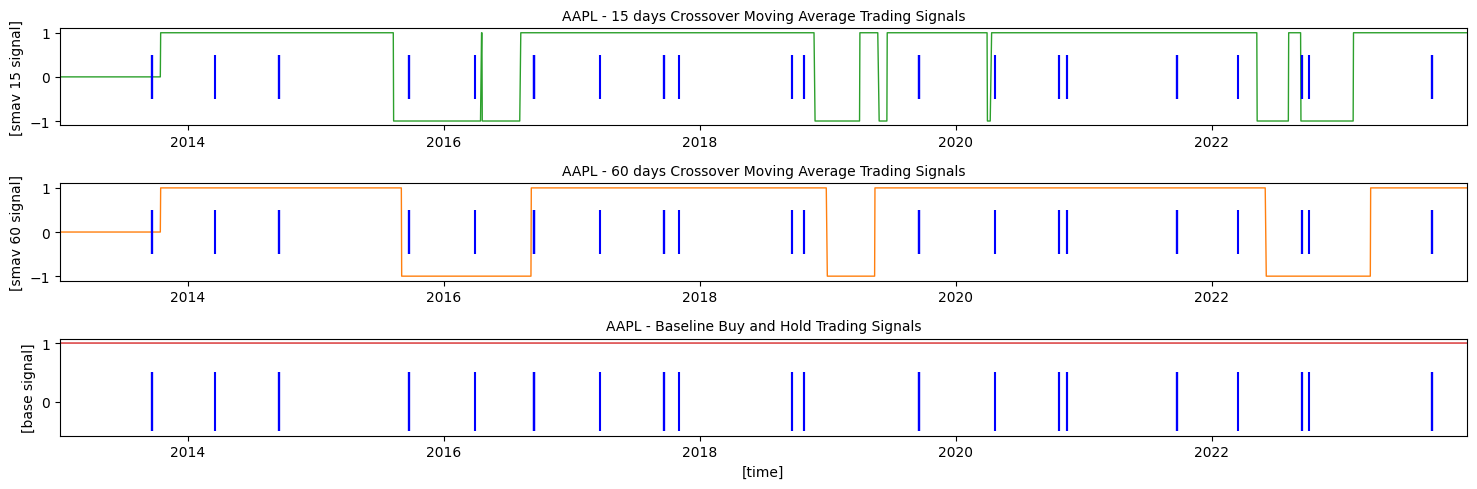

In [65]:
plt.rcParams['figure.figsize'] = [15, 5]
fig, ax = plt.subplots(ncols=1, nrows=3)

ax[0].plot(df_signal['SIGNAL_15'], lw=1.0, color='C2', label='SMAV 15 (red)')
ax[1].plot(df_signal['SIGNAL_60'], lw=1.0, color='C1', label='SMAV 60 (green)')
ax[2].plot(df_signal['SIGNAL_BASE'], lw=1.0, color='C3', label='BASE (purple)')
    
# set axis labels
plt.xlabel('[time]', fontsize=10)
ax[0].set_xlim([start_date, end_date])
ax[0].set_ylabel('[smav 15 signal]', fontsize=10)
ax[1].set_xlim([start_date, end_date])
ax[1].set_ylabel('[smav 60 signal]', fontsize=10)
ax[2].set_xlim([start_date, end_date])
ax[2].set_ylabel('[base signal]', fontsize=10)


# add iphone release data
ax[0].vlines(x = df_timeline[df_timeline['family'] == 'iPhone']['released_dt'].values, 
           ymin = -0.5, ymax = 0.5,
           colors = 'blue',
           label = 'iPhone release date')
ax[1].vlines(x = df_timeline[df_timeline['family'] == 'iPhone']['released_dt'].values, 
           ymin = -0.5, ymax = 0.5,
           colors = 'blue',
           label = 'iPhone release date')
ax[2].vlines(x = df_timeline[df_timeline['family'] == 'iPhone']['released_dt'].values, 
           ymin = -0.5, ymax = 0.5,
           colors = 'blue',
           label = 'iPhone release date')

# rotate the x-axis labels
'''
for tick in ax[0].get_xticklabels():
    tick.set_rotation(45)
    
for tick in ax[1].get_xticklabels():
    tick.set_rotation(45)
    
for tick in ax[2].get_xticklabels():
    tick.set_rotation(45)
'''

# set plot title
ax[0].set_title('AAPL - 15 days Crossover Moving Average Trading Signals', fontsize=10)
ax[1].set_title('AAPL - 60 days Crossover Moving Average Trading Signals', fontsize=10)
ax[2].set_title('AAPL - Baseline Buy and Hold Trading Signals', fontsize=10)

# reset plot layout
plt.tight_layout()

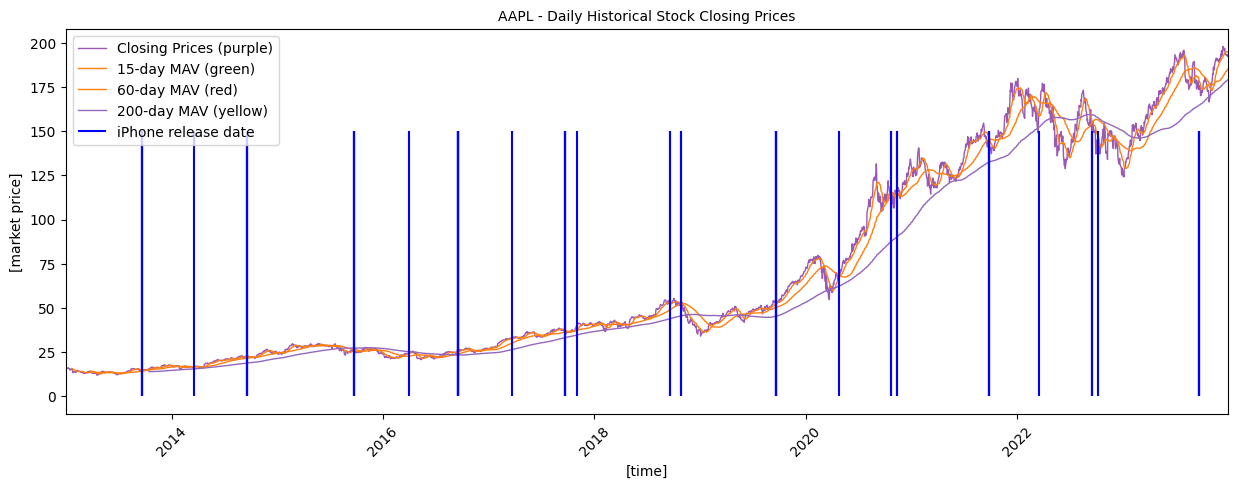

In [66]:
plt.rcParams['figure.figsize'] = [15, 5]
fig = plt.figure()
ax = fig.add_subplot(111)

# plot adjusted closing prices and moving averages
ax.plot(df_smav['Adj_Close'], lw=1.0, color='#9b59b6', label='Closing Prices (purple)')
ax.plot(df_smav['SMAV_15'], color='C1',lw=1.0, label='15-day MAV (green)')
ax.plot(df_smav['SMAV_60'], color='C1',lw=1.0, label='60-day MAV (red)')
ax.plot(df_smav['SMAV_200'], color='C4', lw=1.0, label='200-day MAV (yellow)')

# add iphone release data
plt.vlines(x = df_timeline[df_timeline['family'] == 'iPhone']['released_dt'].values, 
           ymin = 0, ymax = 150,
           colors = 'blue',
           label = 'iPhone release date')

# rotate x-tick labels
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
    
# set axis labels
ax.set_xlabel('[time]', fontsize=10)
ax.set_xlim([start_date, end_date])
ax.set_ylabel('[market price]', fontsize=10)

# set plot legend
plt.legend(loc="upper left", numpoints=1, fancybox=True)

# set plot title
plt.title('AAPL - Daily Historical Stock Closing Prices', fontsize=10);

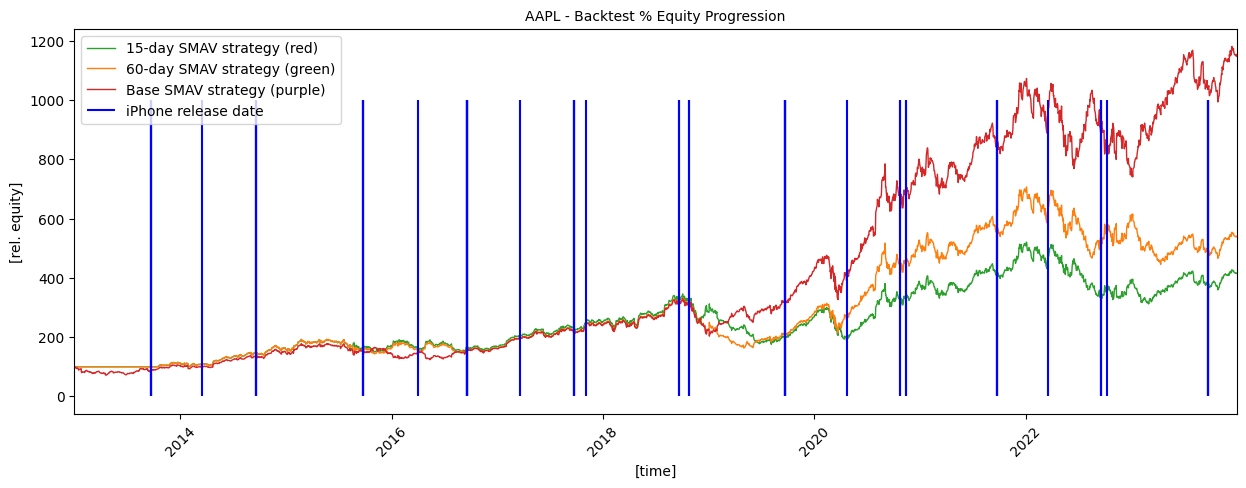

In [67]:
plt.rcParams['figure.figsize'] = [15, 5]
fig = plt.figure()
ax = fig.add_subplot(111)

# plot equity progression of the distinct trading strategies
ax.plot(df_bt_details_15['Rel. EQUITY'], color='C2',lw=1.0, label='15-day SMAV strategy (red)')
ax.plot(df_bt_details_60['Rel. EQUITY'], color='C1',lw=1.0, label='60-day SMAV strategy (green)')
ax.plot(df_bt_details_base['Rel. EQUITY'], color='C3',lw=1.0, label='Base SMAV strategy (purple)')

# add iphone release data
plt.vlines(x = df_timeline[df_timeline['family'] == 'iPhone']['released_dt'].values, 
           ymin = 0, ymax = 1000,
           colors = 'blue',
           label = 'iPhone release date')


# rotate x-tick labels
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
    
# set axis labels
ax.set_xlabel('[time]', fontsize=10)
ax.set_xlim([start_date, end_date])
ax.set_ylabel('[rel. equity]', fontsize=10)

# set plot legend
plt.legend(loc="upper left", numpoints=1, fancybox=True)

# set plot title
plt.title('AAPL - Backtest % Equity Progression', fontsize=10)

plt.show()

# Part 3: future work

In [68]:
# this is just a demo 
# think about where to improve